# Quasi static fracture simulations

## Basic usage

The `matscipy.fracture_mechanics.crack` module provides classes and functions for setting up and analysing atomistic simulations of fracture.

In [22]:
import numpy as np

import ase.io
import ase.units as units
from ase.build import bulk
from ase.constraints import ExpCellFilter
from ase.optimize.precon import PreconLBFGS

from nglview import show_ase

from matscipy.fracture_mechanics.crack import CubicCrystalCrack
from matscipy.fracture_mechanics.clusters import diamond, set_groups
from matscipy.calculators.manybody.explicit_forms.stillinger_weber import StillingerWeber, Holland_Marder_PRL_80_746_Si
from matscipy.calculators.manybody import Manybody



We first setup a manybody calculator using the "inadvertendly modified Stillinger Weber" (IMSW) parameters, in which the strength of the 3-body potential was (initially accidentally) doubled. This is useful for us here as it gives a brittle fracture response.

In [3]:
calc = Manybody(**StillingerWeber(Holland_Marder_PRL_80_746_Si))

### Bulk and Elastic properties

We can use this calculator to find the equilibrium lattice constant for bulk silicon by performing a variable cell relaxation using [ExpCellFilter](https://wiki.fysik.dtu.dk/ase/ase/constraints.html#the-expcellfilter-class) filter and [PreconLBFGS](https://wiki.fysik.dtu.dk/ase/ase/optimize.html#preconditioned-optimizers) optimizer from ASE. Since the cell is very small the preconditioning does not speed up the calculation; however, it is still useful as this is one of the most robust optimizers and it converges quickly. It is not necessary to use a cubic cell, we do it simply to make the calcualation of the cubic lattice constant `alat` straight-forward.

In [4]:
el = 'Si' # chemical element
si = bulk(el, cubic=True)
si.calc = calc
ecf = ExpCellFilter(si)
opt = PreconLBFGS(ecf)
opt.run(fmax=1e-6, smax=1e-6)

PreconLBFGS:   0  13:56:05      -34.692786       0.0000       0.0003


/Users/u1470235/gits/matscipy/venv/lib/python3.10/site-packages/ase/optimize/precon/lbfgs.py:133: UserWarning: The system is likely too small to benefit from the standard preconditioner, hence it is disabled. To re-enable preconditioning, call `PreconLBFGS` by explicitly providing the kwarg `precon`
  warnings.warn('The system is likely too small to benefit from '


PreconLBFGS:   1  13:56:06      -34.692800       0.0000       0.0000


True

In [5]:
a0 = si.cell[0, 0]

Next we compute the elastic constants using `matscipy.elasticity.fit_elastic_constants()` assuming cubic symmetry to reduce the number of calculations required.

In [6]:
from matscipy.elasticity import fit_elastic_constants

si = bulk(el, a=a0)
si.calc = calc
C, C_err = fit_elastic_constants(si, symmetry='cubic')

Fitting C_11
Strain array([-0.02, -0.01,  0.  ,  0.01,  0.02])
Stress array([-4.18433656e+00, -2.05309496e+00,  1.32979590e-05,  1.97563406e+00,
        3.87437477e+00]) GPa
Cij (gradient) / GPa    :     201.4615167357166
Error in Cij / GPa      :     2.647086489317546
Correlation coefficient :     0.9997411342093212
Setting C11 (1) to 1.257424 +/- 0.016522


Fitting C_21
Strain array([-0.02, -0.01,  0.  ,  0.01,  0.02])
Stress array([-1.13682864e+00, -5.40632635e-01,  1.32979590e-05,  4.89079644e-01,
        9.30322868e-01]) GPa
Cij (gradient) / GPa    :     51.640152889484874
Error in Cij / GPa      :     1.7644310200757045
Correlation coefficient :     0.9982534274183545
Setting C21 (7) to 0.322312 +/- 0.011013


Fitting C_31
Strain array([-0.02, -0.01,  0.  ,  0.01,  0.02])
Stress array([-1.13682864e+00, -5.40632635e-01,  1.32979590e-05,  4.89079644e-01,
        9.30322868e-01]) GPa
Cij (gradient) / GPa    :     51.64015288948469
Error in Cij / GPa      :     1.764431020075586
Corr

In [7]:
C_11 = C[0, 0] / units.GPa
C_12 = C[0, 1] / units.GPa
C_44 = C[3, 3] / units.GPa

We extract the cubic elastic constants $C_{11}$, $C_{12}$ and $C_{44}$ and convert to units of GPa:

In [8]:
(C_11, C_12, C_44)

(201.4615167357166, 51.64015288948479, 118.17710649364383)

The remaining ingredient is the surface energy, which we can also compute on-the-fly

In [9]:
# UPDATE to import from here once `adapticecont` branch is merged.
# from matscipy.fracture_mechanics.clusters import find_surface_energy

def find_surface_energy(symbol,calc,a0,surface,size=(8,1,1),vacuum=10,fmax=0.0001,unit='0.1J/m^2'):
    # Import required lattice builder
    if surface.startswith('bcc'):
        from ase.lattice.cubic import BodyCenteredCubic as lattice_builder
    elif surface.startswith('fcc'):
        from ase.lattice.cubic import FaceCenteredCubic as lattice_builder #untested
    elif surface.startswith('diamond'):
        from ase.lattice.cubic import Diamond as lattice_builder #untested
    ## Append other lattice builders here
    else:
        print('Error: Unsupported lattice ordering.')

    # Set orthogonal directions for cell axes
    if surface.endswith('100'):
        directions=[[1,0,0], [0,1,0], [0,0,1]] #tested for bcc
    elif surface.endswith('110'):
        directions=[[1,1,0], [-1,1,0], [0,0,1]] #tested for bcc
    elif surface.endswith('111'):
        directions=[[1,1,1], [-2,1,1],[0,-1,1]] #tested for bcc
    ## Append other cell axis options here
    else:
        print('Error: Unsupported surface orientation.')
    
    # Make bulk and slab with same number of atoms (size)
    bulk = lattice_builder(directions=directions, size=size, symbol=symbol, latticeconstant=a0, pbc=(1,1,1))
    cell = bulk.get_cell() ; cell[0,:] *=2 # vacuum along x axis (surface normal)
    slab = bulk.copy() ; slab.set_cell(cell)
    
    # Optimize the geometries
    from ase.optimize import LBFGSLineSearch
    bulk.calc = calc ; opt_bulk = LBFGSLineSearch(bulk) ; opt_bulk.run(fmax=fmax)
    slab.calc = calc ; opt_slab = LBFGSLineSearch(slab) ; opt_slab.run(fmax=fmax)

    # Find surface energy
    import numpy as np
    Ebulk = bulk.get_potential_energy() ; Eslab = slab.get_potential_energy()
    area = np.linalg.norm(np.cross(slab.get_cell()[1,:],slab.get_cell()[2,:]))
    gamma_ase = (Eslab - Ebulk)/(2*area)

    # Convert to required units
    if unit == 'ASE':
        return [gamma_ase,'ase_units']
    else:
        from ase import units
        gamma_SI = (gamma_ase / units.J ) * (units.m)**2
        if unit =='J/m^2':
            return [gamma_SI,'J/m^2']
        elif unit == '0.1J/m^2':
            return [10*gamma_SI,'0.1J/m^2'] # units required for the fracture code
        else:
            print('Error: Unsupported unit of surface energy.')

In [10]:
surface_energy, unit = find_surface_energy(el, calc, a0, 'diamond111')

                 Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
LBFGSLineSearch:    0 13:56:12     -416.313600*       0.0000


                 Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
LBFGSLineSearch:    0 13:56:12     -403.303800*       0.0000


### Build crack system

We now have all the material parameters needed and can proceed to define the crack system. Usually the contents of the cell below (together with the code above to compute the elastic constants and surface energy) would be included in a file named `params.py` which would then be imported by the scripts in `matscipy/fracture_mechanics/scripts`, e.g. the `quasistatic_crack.py` script on which this tutorial is based.

In [69]:
n               = [ 4, 4, 1 ]
crack_surface   = [ 1, 1, 1 ]
crack_front     = [ 1, -1, 0 ]
crack_tip       = [ 41, 56 ]
skin_x, skin_y = 1, 1

vacuum          = 6.0
fmax            = 0.05

# Setup crack system
cryst = diamond(el, a0, n, crack_surface, crack_front)
set_groups(cryst, n, skin_x, skin_y)

ase.io.write('cryst.cfg', cryst)

# Compute crack tip position
r0 = np.sum(cryst.get_positions()[crack_tip,:], axis=0)/len(crack_tip)
tip_x0, tip_y0, tip_z0 = r0

skin_x = 1*a0, skin_y = 1*a0
skin_x = 6.651528178589903, skin_y = 9.406681360668651


We can now visualise the crystall unit cell:

In [70]:
show_ase(cryst)

NGLWidget()

We define a `CubicCrystalCrack` object to represent our crack system. This takes the crystal orientations and the elastic constants (either as three cubic constant as we do here, or as a full 6x6 stiffness matrix in either the crystal reference frame or rotated to the specimen frame).

In [71]:
crk = CubicCrystalCrack(crack_surface, crack_front,
                        C_11, C_12, C_44)

By providing the surface energy, the `crk` object can be used to compute the Griffith estimate of the critical stress intensity factor at which fracture becomes thermodynamically favourable.

In [72]:
k1g = crk.k1g(surface_energy)
k1g

70.85631549727216

### Apply initial strain field

We have everything we need to apply the continuum linear elastic displacement field to our crystal. We centred the field on the middle of the `cryst` structure.

In [73]:
tip_x = cryst.cell.diagonal()[0]/2
tip_y = cryst.cell.diagonal()[1]/2

crack = cryst.copy()
crack.set_pbc([False, False, True])

k1 = 1.0

ux, uy = crk.displacements(cryst.positions[:,0], cryst.positions[:,1],
                            tip_x, tip_y, k1*k1g)
crack.positions[:, 0] += ux
crack.positions[:, 1] += uy

# Center notched configuration in simulation cell and ensure enough vacuum.
oldr = crack[0].position.copy()
crack.center(vacuum=vacuum, axis=0)
crack.center(vacuum=vacuum, axis=1)
tip_x += crack[0].x - oldr[0]
tip_y += crack[0].y - oldr[1]

show_ase(crack)

NGLWidget()

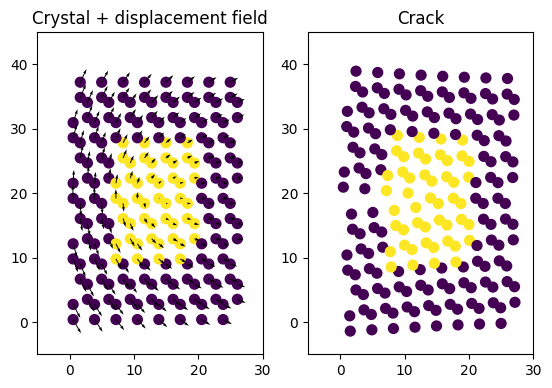

In [81]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.scatter(cryst.positions[:,0], cryst.positions[:,1], s=50, c=cryst.arrays['groups'])
ax1.quiver(cryst.positions[:,0], cryst.positions[:,1], ux, uy)
ax2.scatter(cryst.positions[:,0] + ux, cryst.positions[:,1] + uy, s=50, c=cryst.arrays['groups'])

ax1.set_title('Crystal + displacement field')
ax2.set_title('Crack')

for ax in [ax1, ax2]:
    ax.set_aspect('equal')
    # ax.set_xticks([])
    # ax.set_yticks([])
    ax.set_xlim(-5, 30)
    ax.set_ylim(-5, 45)    
    pass